<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisCuantitativoAvanzado/blob/main/SeriesdeTiempo/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo ARIMA

La primera parte es toda igual.

Primero importamos todas las librerías necesarias, solo que esta vez incluimos la librería statsmodels

In [1]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels

import matplotlib.pyplot as plt

In [2]:
from google.colab import userdata

# Definir user key para la API
user_key = userdata.get('ALPHACAST')

Obsérvese que tomamos la serie sin estacionalidad, en vez de la serie original.

In [3]:
# EMAE
emae = requests.get('https://api.alphacast.io/datasets/5331/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('emae.csv','wb').write(emae.content)
emae = pd.read_csv('emae.csv',delimiter = ',')

emae['Date'] = pd.to_datetime(emae['Date'])
emae.set_index('Date', inplace = True)

emae = emae['Emae - sa_orig - current_prices_mom']
emae.columns = ['Emae - sa_orig - current_prices_mom']
emae = emae.loc['2016-02-01':]

In [4]:
# IPI
ipi = requests.get('https://api.alphacast.io/datasets/5679/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('ipi.csv','wb').write(ipi.content)
ipi = pd.read_csv('ipi.csv',delimiter = ',')


ipi['Date'] = pd.to_datetime(ipi['Date'])
ipi.set_index('Date', inplace = True)
ipi = ipi[(ipi['Division'] == "IPI Manufacturero") & (ipi['Seasonal Adjustment'] == "Seasonally Adjusted")]
ipi = ipi['Value - current_prices_mom']
ipi.columns = ['Value - sa_MoM']
ipi = ipi.loc['2016-02-01':]

In [5]:
# ISAC
isac = requests.get('https://api.alphacast.io/datasets/5565/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('isac.csv','wb').write(isac.content)
isac = pd.read_csv('isac.csv',delimiter = ',')


isac['Date'] = pd.to_datetime(isac['Date'])
isac.set_index('Date', inplace = True)
isac = isac['Nivel general - sa_orig - current_prices_mom']
isac.columns = ['Nivel general - sa_MoM']
isac = isac.loc['2016-02-01':]

Preparamos una función para graficar

In [6]:
sns.set_theme(style='darkgrid')
def graficar(variable):
    fig = sns.lineplot(x=variable.index, y=variable)
    plt.title(variable.name)
    plt.xlabel("Año")
    plt.savefig('%s.png'%variable.name)
    return fig

Y la graficamos. ¿Es estacionaria? No confundir estacional con estacionaria

<Axes: title={'center': 'Emae - sa_orig - current_prices_mom'}, xlabel='Año', ylabel='Emae - sa_orig - current_prices_mom'>

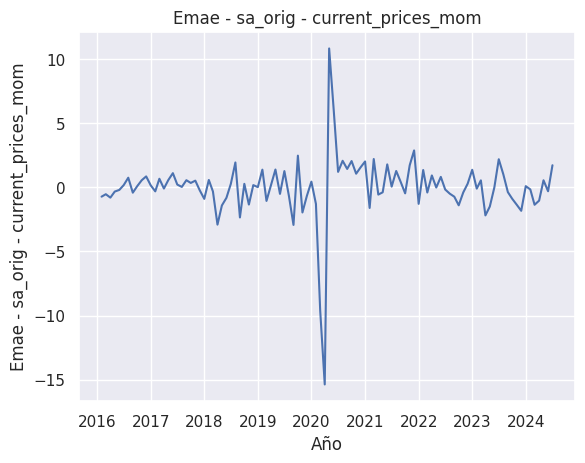

In [7]:
graficar(emae)

<Axes: title={'center': 'Value - current_prices_mom'}, xlabel='Año', ylabel='Value - current_prices_mom'>

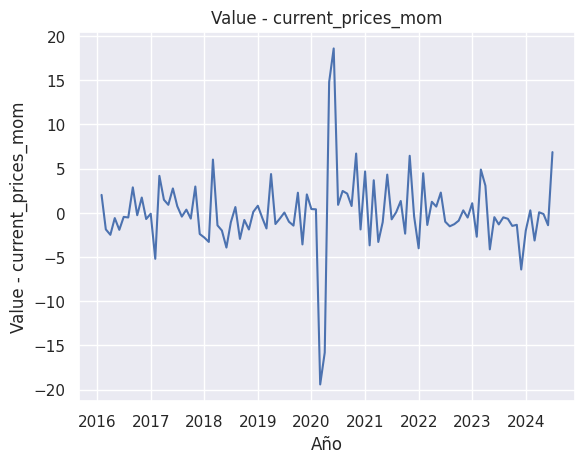

In [8]:
graficar(ipi)

<Axes: title={'center': 'Nivel general - sa_orig - current_prices_mom'}, xlabel='Año', ylabel='Nivel general - sa_orig - current_prices_mom'>

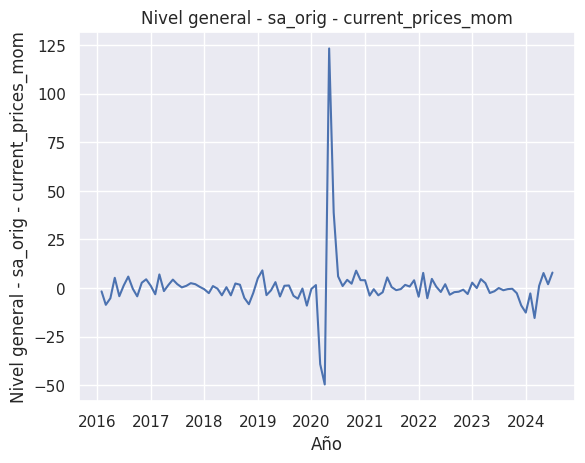

In [9]:
graficar(isac)

Chequeamos si la serie es estacionaria con el test de Dickey-Fuller aumentado del paquete Statsmodels.

La H0 del modelo es que la serie tiene raíz unitaria, es decir que no es estacionaria.

El p-value para los tres casos es <= 0.05 quiere decir que se puede rechazar la H0 y por tanto se asume que la serie es estacionaria. ¿Por qué? Ayuda: trajimos las series en diferencias.

In [10]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(ipi)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.612888
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582


# Modelo simple con StatsModel

In [11]:
frame = { 'EMAE': emae, 'IPI': ipi , 'ISAC': isac}
df = pd.DataFrame(frame)

In [12]:
results = smf.ols('EMAE ~ IPI + ISAC', data=df).fit()

In [13]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   EMAE   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     136.8
Date:                Thu, 03 Oct 2024   Prob (F-statistic):           3.19e-29
Time:                        17:45:40   Log-Likelihood:                -169.19
No. Observations:                 102   AIC:                             344.4
Df Residuals:                      99   BIC:                             352.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0446      0.128     -0.349      0.7

In [17]:
X =  pd.DataFrame({'IPI': [df['IPI'][-1]], 'ISAC': [df['ISAC'][-1]]})

<ipython-input-17-758ba9076bad>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X =  pd.DataFrame({'IPI': [df['IPI'][-1]], 'ISAC': [df['ISAC'][-1]]})


In [18]:
X

,IPI,ISAC
0,6.873029,7.969635


In [19]:
print(results.predict(X)[0])

2.4791161627100378


In [20]:
df[-5:]

,EMAE,IPI,ISAC
Date,,,
2024-03-01,-1.365632,-3.126307,-15.388856
2024-04-01,-1.041793,0.069197,1.122882
2024-05-01,0.544140,-0.132622,7.730018
2024-06-01,-0.310364,-1.399190,1.965143
2024-07-01,1.717319,6.873029,7.969635


# Modelo ARIMA

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
df.EMAE[:-1]

,EMAE
Date,
2016-02-01,-0.732842
2016-03-01,-0.542077
2016-04-01,-0.808724
2016-05-01,-0.334856
2016-06-01,-0.207642
...,...
2024-02-01,-0.169671
2024-03-01,-1.365632
2024-04-01,-1.041793


In [46]:
mod = ARIMA(df.EMAE , order=(1, 0, 1))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   EMAE   No. Observations:                  102
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -233.490
Date:                Thu, 03 Oct 2024   AIC                            474.980
Time:                        18:19:18   BIC                            485.479
Sample:                    02-01-2016   HQIC                           479.231
                         - 07-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.328     -0.015      0.988      -0.649       0.638
ar.L1         -0.8187      0.070    -11.755      0.000      -0.955      -0.682
ma.L1          0.9778      0.055     17.820      0.0

# Predicción

In [49]:
X = df['EMAE'].loc['2016-02-01':]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [50]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(1,0,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

<ipython-input-50-372e6cb67397>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted=0.034700, expected=-0.404214
predicted=-0.046942, expected=0.277750
predicted=0.154514, expected=1.361779
predicted=0.168130, expected=-0.105290
predicted=-0.097854, expected=0.538130
predicted=0.284925, expected=-2.193838
predicted=-0.598423, expected=-1.502797
predicted=0.361451, expected=-0.007755
predicted=-0.340715, expected=2.185203
predicted=0.758168, expected=1.009476
predicted=-0.503075, expected=-0.377875
predicted=0.506467, expected=-0.903607
predicted=-0.591430, expected=-1.370867
predicted=0.388387, expected=-1.835958
predicted=-0.690705, expected=0.086541
predicted=0.683695, expected=-0.169671
predicted=-0.706614, expected=-1.365632
predicted=0.448141, expected=-1.041793
predicted=-0.659834, expected=0.544140
predicted=0.669349, expected=-0.310364
predicted=-0.717472, expected=1.717319


In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.303


In [52]:
import numpy as np
df['prediction'] = np.nan
df.iloc[-len(predictions):, df.columns.get_loc('prediction')] = predictions

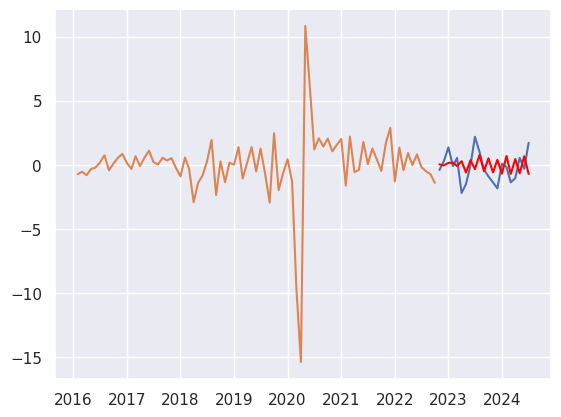

In [53]:
from matplotlib import pyplot
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(train)
pyplot.plot(df['prediction'], color='red')
pyplot.show()